In [2]:
# 导入相关的包
import torch
from torch import nn
from torch.utils.data import Dataset
import os
import torch.nn.functional as F
import pandas as pd
# 导入transform
from torchvision import transforms
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import time
# 指定训练设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
# 导入train.csv文件
train_dataframe = pd.read_csv('./classify-leaves/train.csv',header=None)
# 看看前五行长什么样
print("Train DataFrame:")
print(train_dataframe.head())
print(len(train_dataframe.head().index))


Train DataFrame:
              0                 1
0         image             label
1  images/0.jpg  maclura_pomifera
2  images/1.jpg  maclura_pomifera
3  images/2.jpg  maclura_pomifera
4  images/3.jpg  maclura_pomifera
5


In [23]:
#  使用集合去除重复的标签值
#  把label文件排个序
leaves_labels = sorted(list(set(train_dataframe['label'])))
n_classes = len(leaves_labels)
print(f"标签个数:{n_classes}")
#  打印前10个标签
leaves_labels[:10]

标签个数:176


['abies_concolor',
 'abies_nordmanniana',
 'acer_campestre',
 'acer_ginnala',
 'acer_griseum',
 'acer_negundo',
 'acer_palmatum',
 'acer_pensylvanicum',
 'acer_platanoides',
 'acer_pseudoplatanus']

In [24]:
# 把label转成对应的数字
class_to_num = dict(zip(leaves_labels, range(n_classes)))
class_to_num

{'abies_concolor': 0,
 'abies_nordmanniana': 1,
 'acer_campestre': 2,
 'acer_ginnala': 3,
 'acer_griseum': 4,
 'acer_negundo': 5,
 'acer_palmatum': 6,
 'acer_pensylvanicum': 7,
 'acer_platanoides': 8,
 'acer_pseudoplatanus': 9,
 'acer_rubrum': 10,
 'acer_saccharinum': 11,
 'acer_saccharum': 12,
 'aesculus_flava': 13,
 'aesculus_glabra': 14,
 'aesculus_hippocastamon': 15,
 'aesculus_pavi': 16,
 'ailanthus_altissima': 17,
 'albizia_julibrissin': 18,
 'amelanchier_arborea': 19,
 'amelanchier_canadensis': 20,
 'amelanchier_laevis': 21,
 'asimina_triloba': 22,
 'betula_alleghaniensis': 23,
 'betula_jacqemontii': 24,
 'betula_lenta': 25,
 'betula_nigra': 26,
 'betula_populifolia': 27,
 'broussonettia_papyrifera': 28,
 'carpinus_betulus': 29,
 'carpinus_caroliniana': 30,
 'carya_cordiformis': 31,
 'carya_glabra': 32,
 'carya_ovata': 33,
 'carya_tomentosa': 34,
 'castanea_dentata': 35,
 'catalpa_bignonioides': 36,
 'catalpa_speciosa': 37,
 'cedrus_atlantica': 38,
 'cedrus_deodara': 39,
 'cedru

In [25]:
# 再转换回来，方便最后预测的时候使用
num_to_class = {v : k for k, v in class_to_num.items()}
num_to_class

{0: 'abies_concolor',
 1: 'abies_nordmanniana',
 2: 'acer_campestre',
 3: 'acer_ginnala',
 4: 'acer_griseum',
 5: 'acer_negundo',
 6: 'acer_palmatum',
 7: 'acer_pensylvanicum',
 8: 'acer_platanoides',
 9: 'acer_pseudoplatanus',
 10: 'acer_rubrum',
 11: 'acer_saccharinum',
 12: 'acer_saccharum',
 13: 'aesculus_flava',
 14: 'aesculus_glabra',
 15: 'aesculus_hippocastamon',
 16: 'aesculus_pavi',
 17: 'ailanthus_altissima',
 18: 'albizia_julibrissin',
 19: 'amelanchier_arborea',
 20: 'amelanchier_canadensis',
 21: 'amelanchier_laevis',
 22: 'asimina_triloba',
 23: 'betula_alleghaniensis',
 24: 'betula_jacqemontii',
 25: 'betula_lenta',
 26: 'betula_nigra',
 27: 'betula_populifolia',
 28: 'broussonettia_papyrifera',
 29: 'carpinus_betulus',
 30: 'carpinus_caroliniana',
 31: 'carya_cordiformis',
 32: 'carya_glabra',
 33: 'carya_ovata',
 34: 'carya_tomentosa',
 35: 'castanea_dentata',
 36: 'catalpa_bignonioides',
 37: 'catalpa_speciosa',
 38: 'cedrus_atlantica',
 39: 'cedrus_deodara',
 40: 'c

In [26]:
# 继承pytorch的dataset，创建自己的
class LeavesData(Dataset):
    def __init__(self, csv_path, file_path, mode='train', valid_ratio=0.2, resize_height=256, resize_width=256):
        """
        Args:
            csv_path (string): csv 文件路径
            img_path (string): 图像文件所在路径
            mode (string): 训练模式还是测试模式
            valid_ratio (float): 验证集比例
        """
        
        # 需要调整后的照片尺寸，我这里每张图片的大小尺寸不一致#
        self.resize_height = resize_height
        self.resize_width = resize_width

        self.file_path = file_path
        self.mode = mode

        # 读取 csv 文件
        # 利用pandas读取csv文件
        self.data_info = pd.read_csv(csv_path, header=None)  #header=None是去掉表头部分
        # 计算 length
        self.data_len = len(self.data_info.index) - 1 
        self.train_len = int(self.data_len * (1 - valid_ratio)) # 训练集的前百分之八十用来训练
        
        if mode == 'train':
            # 第一列包含图像文件的名称
            self.train_image = np.asarray(self.data_info.iloc[1:self.train_len, 0])  #self.data_info.iloc[1:,0]表示读取第一列，从第二行开始到train_len
            # 第二列是图像的 label
            self.train_label = np.asarray(self.data_info.iloc[1:self.train_len, 1])
            self.image_arr = self.train_image 
            self.label_arr = self.train_label
        elif mode == 'valid':
            self.valid_image = np.asarray(self.data_info.iloc[self.train_len:, 0])  
            self.valid_label = np.asarray(self.data_info.iloc[self.train_len:, 1])
            self.image_arr = self.valid_image
            self.label_arr = self.valid_label
        elif mode == 'test':
            self.test_image = np.asarray(self.data_info.iloc[1:, 0])
            self.image_arr = self.test_image
            
        self.real_len = len(self.image_arr)

        print('Finished reading the {} set of Leaves Dataset ({} samples found)'
              .format(mode, self.real_len))

    def __getitem__(self, index):
        # 从 image_arr中得到索引对应的文件名
        single_image_name = self.image_arr[index]

        # 读取图像文件
        img_as_img = Image.open(self.file_path + single_image_name)

        #如果需要将RGB三通道的图片转换成灰度图片可参考下面两行
#         if img_as_img.mode != 'L':
#             img_as_img = img_as_img.convert('L')

        #设置好需要转换的变量，还可以包括一系列的nomarlize等等操作
        if self.mode == 'train':
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=0.5),   #随机水平翻转 选择一个概率
                transforms.ToTensor()
            ])
        else:
            # valid和test不做数据增强
            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor()
            ])
        
        img_as_img = transform(img_as_img)
        
        if self.mode == 'test':
            return img_as_img
        else:
            # 得到图像的 string label
            label = self.label_arr[index]
            # number label
            number_label = class_to_num[label]

            return img_as_img, number_label  #返回每一个index对应的图片数据和对应的label

    def __len__(self):
        return self.real_len

In [27]:
# 设置数据集路径
train_path = './classify-leaves/train.csv'
test_path = './classify-leaves/test.csv'
# csv文件中已经images的路径了，因此这里只到上一级目录
img_path = './classify-leaves/'

train_dataset = LeavesData(train_path, img_path, mode='train')
val_dataset = LeavesData(train_path, img_path, mode='valid')
test_dataset = LeavesData(test_path, img_path, mode='test')
# print(train_dataset)
# print(val_dataset)
# print(test_dataset)

Finished reading the train set of Leaves Dataset (14681 samples found)
Finished reading the valid set of Leaves Dataset (3672 samples found)
Finished reading the test set of Leaves Dataset (8800 samples found)


In [28]:
# 创建数据加载器
# 定义data loader
train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=32, 
        shuffle=False
    )

val_loader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=16, 
        shuffle=False
    )
test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=16, 
        shuffle=False
    )

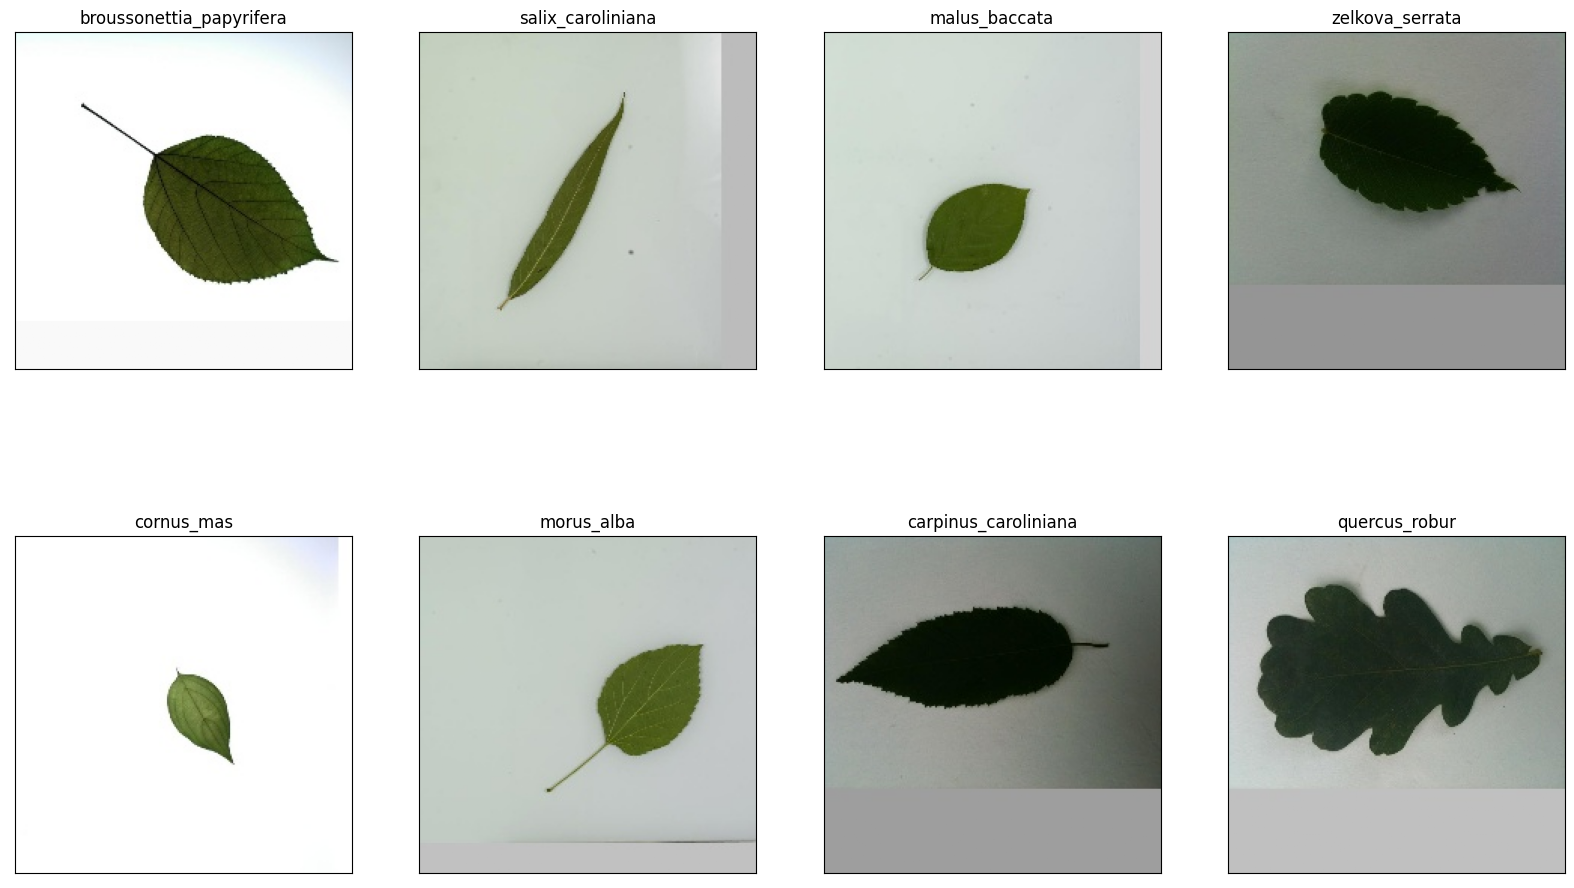

In [29]:
# 展示一下数据长啥样
# 用于将 PyTorch 张量转换为可显示的图像。
def im_convert(tensor):
    """ 展示数据"""
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze() # 将 PyTorch 张量转换为 NumPy 数组。去除数组中大小为 1 的维度即batch 维度。
    image = image.transpose(1,2,0) # 将 (C, H, W) 转换为 (H, W, C)
    image = image.clip(0, 1) #将像素值限制在 0 和 1 之间

    return image

fig=plt.figure(figsize=(20, 12))
columns = 4
rows = 2

dataiter = iter(val_loader)
inputs, classes = dataiter.next()
# print(inputs.shape)
# print(classes.shape)
for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    ax.set_title(num_to_class[int(classes[idx])])
    plt.imshow(im_convert(inputs[idx]))

plt.show()

In [30]:
# 看一下是在cpu还是GPU上
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'

device = get_device()
print(device)

cuda


In [31]:
# 保存数据集的长度
train_dataset_size = len(train_dataset)
val_dataset_size = len(val_dataset)
test_dataset_size = len(test_dataset)
print("训练数据集的长度为：{}".format(train_dataset_size))
print("验证数据集的长度为：{}".format(val_dataset_size))
print("测试数据集的长度为：{}".format(test_dataset_size))

训练数据集的长度为：14681
验证数据集的长度为：3672
测试数据集的长度为：8800


In [32]:
# 定义一个残差块
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y+=X
        return F.relu(Y)

In [33]:
# 定义残差网络
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *resnet_block(64, 64, 2, first_block=True),
            *resnet_block(64, 128, 2),
            *resnet_block(128, 256, 2),
            *resnet_block(256, 512, 2),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(512, 176)
        )
    def forward(self, x):
        return self.model(x)
    


In [34]:
# 初始化模型参数
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
net = ResNet18()
net.to(device)
net.apply(init_weights)

ResNet18(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (5): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d

In [35]:
# 批大小
batch_size = 64
# 保存的模型名字
model_name = 'resnet18_leaves_classify'

# 损失函数
loss_fn = nn.CrossEntropyLoss()
loss_fn.to(device)

# 优化器
learn_rate = 0.01
optimizer = torch.optim.SGD(net.parameters(), lr=learn_rate, momentum=0.9, weight_decay=5e-4)
# 学习率调整器
# 每30轮学习率变为原来的0.1
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)


In [36]:
# 设置训练网络的一些记录数
# 记录已训练的总次数
total_train_step = 0
# 记录已训练的总样本数
total_train_data = 0
# 记录测试的次数
total_val_step = 0
# 记录训练时间
total_train_time = 0
# 收集每轮训练 的平均loss用于绘图
train_loss_map = []
# 收集每轮训练的正确率用于绘图
train_accuracy_map = []
# 收集每轮的测试的loss用于绘图
val_loss_map = []
# 收集每轮测试的正确率用于绘图
val_accuracy_map = []

# 设置训练网络的循环次数
train_epoch = 135

In [37]:
# 绘图函数
def draw_loss_and_accuracy_curves(train_loss_map, test_loss_map, train_accuracy_map, test_accuracy_map):
    epochs = range(1, len(train_loss_map) + 1)
    plt.figure(figsize=(10, 8))
    # 绘制训练损失曲线
    plt.plot(epochs, train_loss_map, 'o-', color='blue', label='Train Loss')
    # 绘制测试损失曲线
    plt.plot(epochs, test_loss_map, 'o-', color='green', label='Test Loss')
    # 绘制训练准确率曲线（使用虚线）
    plt.plot(epochs, train_accuracy_map, 's--', color='red', label='Train Accuracy')
    # 绘制测试准确率曲线（使用虚线）
    plt.plot(epochs, test_accuracy_map, 's--', color='orange', label='Test Accuracy')
    plt.xlabel('Epoch')  # X轴标签
    plt.ylabel('Value')  # Y轴标签
    plt.title('Training and Testing Loss and Accuracy')  # 图标题
    plt.legend()  # 显示图例
    plt.grid(True)  # 显示网格
    # 设置X轴的刻度为整数
    plt.xticks(epochs, [f'{i}' for i in epochs], rotation=45)
    plt.show()

In [38]:
# 开始训练
for i in range(train_epoch):
    print(f"----------------------第{i + 1}轮训练开始----------------------")
    # 开始计时
    start_time = time.time()
    # 训练步骤开始
    net.train()
    # 记录一轮训练的次数
    epoch_train_step = 0
    # 记录一轮训练的总误差
    epoch_train_loss = 0
    # 记录一轮训练正确的样本数
    epoch_train_right_data = 0
    for data in train_loader:
        # 计算损失值
        images, targets = data
        images = images.to(device)
        targets = targets.to(device)
        outputs = net(images)
        loss = loss_fn(outputs, targets)
        # 反向传播更新梯度
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 更新记录值
        total_train_step += 1  # 总训练次数加1
        epoch_train_step += 1  # 单轮训练次数加1
        total_train_data += batch_size  # 总训练样本数加上批数
        epoch_train_loss += loss.item()  # 单轮训练总误差更新
        accuracy = (outputs.argmax(1) == targets).sum().item()  # 一个批次训练正确的样本数
        epoch_train_right_data += accuracy  # 一轮训练正确的样本数更新
        if total_train_step % 100 == 0:
            print("训练次数：{}|训练样本数：{}|单次训练误差(loss):{}".format(total_train_step, total_train_data,
                                                                           loss.item()))
    # 计算一轮训练的平均loss
    epoch_train_average_loss = epoch_train_loss / epoch_train_step
    train_loss_map.append(epoch_train_average_loss)  # 将数据加入到列表中用于绘图
    # 计算一轮训练的正确率
    epoch_train_accuracy = epoch_train_right_data / train_dataset_size
    train_accuracy_map.append(epoch_train_accuracy)

    # 测试步骤开始
    net.eval()
    with torch.no_grad():
        # 一轮测试的总误差
        epoch_val_loss = 0
        # 一轮测试的次数
        epoch_val_step = 0
        # 一轮测试的正确次数
        epoch_val_right_data = 0
        for data in val_loader:
            # 计算损失值
            images, targets = data
            images = images.to(device)
            targets = targets.to(device)
            outputs = net(images)
            loss = loss_fn(outputs, targets)
            # 更新记录值
            epoch_val_loss += loss.item()
            accuracy = (outputs.argmax(1) == targets).sum().item()
            epoch_val_right_data += accuracy
            epoch_val_step += 1
    total_val_step += 1
    # 结束计时
    end_time = time.time()
    elapsed_time = end_time - start_time
    total_train_time += elapsed_time
    print(f"本轮训练时间:{elapsed_time:.4f}s")
    print(f"累积训练时间:{total_train_time:.4f}s")

    # 计算一轮测试的平均loss
    epoch_val_average_loss = epoch_val_loss / epoch_val_step
    val_loss_map.append(epoch_val_average_loss)  # 将数据加入到列表中用于绘图
    # 计算一轮测试的正确率
    epoch_val_accuracy = epoch_val_right_data / val_dataset_size
    val_accuracy_map.append(epoch_val_accuracy)

    # 输出一个轮次的信息
    # 训练信息
    print(f"------训练数据------")
    print(f"本轮训练集上总误差(train_total_loss):{epoch_train_loss}")
    print(f"本轮训练集上的平均误差(train_average_loss):{epoch_train_average_loss}")
    print(f"本轮训练集上的正确率(train_accuracy):{epoch_train_right_data / train_dataset_size}")
    # 测试信息
    print(f"------测试数据------")
    print(f"本轮测试集上总误差(val_total_loss):{epoch_val_loss}")
    print(f"本轮测试集上的平均误差(val_average_loss):{epoch_val_average_loss}")
    print(f"本轮测试集上的正确率(val_accuracy):{epoch_val_right_data / val_dataset_size}")

    # 创建文件夹用来保存模型
    dir_path = os.path.join(".", "模型保存", "{}".format(model_name))
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    # 保存每一轮模型
    torch.save(net.state_dict(), "./模型保存/" + "{}/".format(model_name) + "net{}.pth".format(i))
    print("模型保存成功")

    # 更新学习率
    scheduler.step()

----------------------第1轮训练开始----------------------
训练次数：100|训练样本数：6400|单次训练误差(loss):4.72088623046875


KeyboardInterrupt: 

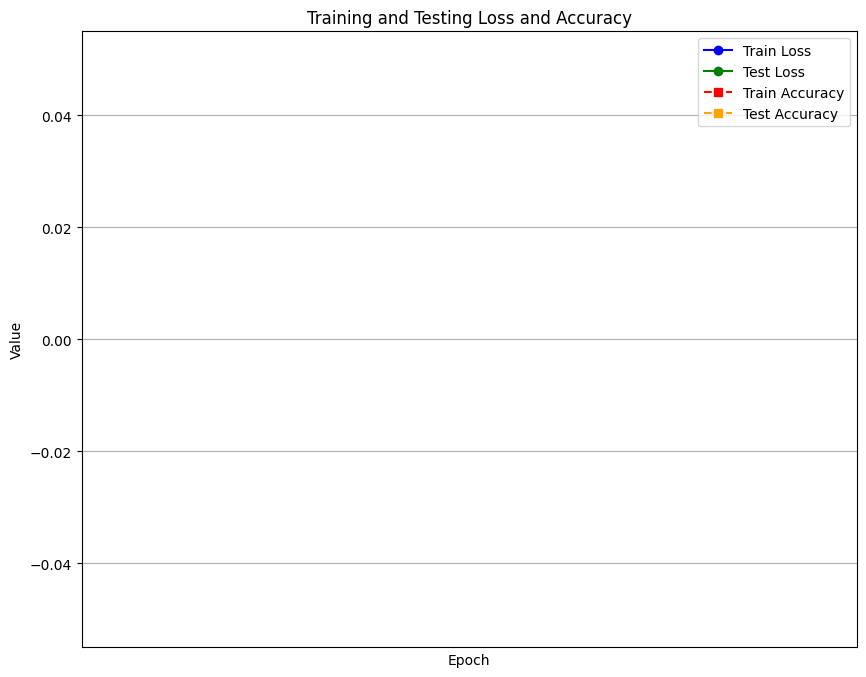

In [39]:
# 绘图
draw_loss_and_accuracy_curves(train_loss_map, val_loss_map, train_accuracy_map, val_accuracy_map)

In [ ]:
# 预测
model = ResNet18()
model = model.to(device)
model.load_state_dict(torch.load('./模型保存'))

model.eval()
predictions = []

for data in test_loader:
    images = data

    with torch.no_grad():
        outputs = model(images.to(device))

    predictions.extend(outputs.argmax(dim=-1).cpu().numpy().tolist())

preds = []
for i in predictions:
    preds.append(num_to_class[i])

test_data = pd.read_csv(test_path)
test_data['label'] = pd.Series(preds)
submission = pd.concat([test_data['image'],test_data['label']],axis=1)
submission.to_csv('submission.csv',index=False)    
    